In [33]:
# importing necessary libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

In [34]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
#print(soup.prettify())

Get HTML from wikipedia
Use BeautifySoup to parse html data
Store parsed data into Pandas DataFrame

In [35]:
#imports
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np



#get html from wiki page and create soup object
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')

#using soup object, iterate the .wikitable to get the data from the HTML page and store it into a list
data = []
columns = []
table = soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    
    #First row of data is the header
    if (index == 0):
        columns = section
    else:
        data.append(section)

#convert list into Pandas DataFrame
canada_df = pd.DataFrame(data = data,columns = columns)
canada_df.head()
   

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Remove Boroughs that are 'Not assigned'
More than one neighborhood can exist in one postal code area, combined these into one row with the neighborhoods separated with a comma
If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [36]:
#Remove Boroughs that are 'Not assigned'
canada_df = canada_df[canada_df['Borough'] != 'Not assigned']
canada_df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Remove Boroughs that are 'Not assigned'
More than one neighborhood can exist in one postal code area, combined these into one row with the neighborhoods separated with a comma
If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [37]:
#Remove Boroughs that are 'Not assigned'
canada_df = canada_df[canada_df['Borough'] != 'Not assigned']
canada_df.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [38]:
# More than one neighborhood can exist in one postal code area, combined these into one row with the neighborhoods separated with a comma
canada_df["Neighbourhood"] = canada_df.groupby("Postal Code")["Neighborhood"].transform(lambda neigh: ', '.join(neigh))

#remove duplicates
canada_df = canada_df.drop_duplicates()

#update index to be postcode if it isn't already
if(canada_df.index.name != 'Postal Code'):
    canada_df = canada_df.set_index('Postal Code')
    
canada_df.head()

,Borough,Neighborhood,Neighbourhood
Postal Code,,,
M3A,North York,Parkwoods,Parkwoods
M4A,North York,Victoria Village,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront","Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights","Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government","Queen's Park, Ontario Provincial Government"


In [39]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough
canada_df['Neighbourhood'].replace("Not assigned", canada_df["Borough"],inplace=True)
canada_df.head()

,Borough,Neighborhood,Neighbourhood
Postal Code,,,
M3A,North York,Parkwoods,Parkwoods
M4A,North York,Victoria Village,Victoria Village
M5A,Downtown Toronto,"Regent Park, Harbourfront","Regent Park, Harbourfront"
M6A,North York,"Lawrence Manor, Lawrence Heights","Lawrence Manor, Lawrence Heights"
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government","Queen's Park, Ontario Provincial Government"


In [40]:

canada_df.shape

(103, 3)

Loading csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

In [41]:
df_geo_coor = pd.read_csv("http://cocl.us/Geospatial_data")
df_geo_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging 2 dataframes "canada_df" and "df_geo_coor" into one dataframe.

In [42]:
df_toronto = pd.merge(canada_df, df_geo_coor, how='left', left_on = 'Postal Code', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,Borough,Neighborhood,Neighbourhood,Latitude,Longitude
0,North York,Parkwoods,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront","Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights","Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government","Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [43]:
df_toronto.shape

(103, 5)

Using geopy Library to get the Coordinates of Toronto


In [44]:
from geopy.geocoders import Nominatim
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Creating a map of Toronto with neighborhoods superimposed on top

In [47]:
import folium # map rendering library
!pip install folium

In [48]:
m = folium.Map(location=[43.6534817, -79.3839347])

folium.CircleMarker(
        [43.6534817, -79.3839347],
        radius=3,
        weight=2,
        color='#333333',
        fill=True,
        fill_color='#388e3c',
        fill_opacity=0.7,
        parse_html=False).add_to(m)  

In [49]:
m

Retrieving Venue Data For Toronto


In [51]:
CLIENT_ID = 'HBD22ML12L5425CSRYIP4IDE2LEKIPCGZ3JKZPQTUYV0NIHZ' 
CLIENT_SECRET = 'EYDQ1R5RNMEHVHO2KBH553FLK04FMROAWYUUVSCQNOEHFJWP' 
VERSION = '20180605'
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    """
    A function that retrieves information about venues in each neighborhood.
    It takes as input a list of the names of the neighborhoods, a list of 
    their latitudes, and a list of their longitudes.
    It returns a dataframe with information about each neighborhood and its venues.
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('•', end='')
            
        # create the API request URL
        url = ('https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}'
               '&v={}&ll={},{}&intent=browse&radius={}&limit={}'
               .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT))
            
        # make the GET request
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]["venues"]
            except:
                print('X', end='')
                results = None
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['name'], v['location']['lat'], 
                             v['location']['lng'], v['categories'][0]['name']) 
                            for v in results if len(v['categories']) > 0])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)
    
    
    
    
    


In [52]:
tor_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                             latitudes=df_toronto['Latitude'],
                             longitudes=df_toronto['Longitude']
                            )

•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••

In [53]:
# Removing records where venue is "building" or "office"
tor_venues = tor_venues[~tor_venues['Venue Category'].isin(['Building', 'Office', 'Bus Line', 'Bus Station', 'Bus Stop', 'Road'])]
print(tor_venues.shape)
tor_venues.head()

(7797, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Subway,43.760334,-79.326906,Sandwich Place
3,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
4,Parkwoods,43.753259,-79.329656,CAPREIT Apartments,43.753920,-79.322400,Residential Building (Apartment / Condo)
5,Parkwoods,43.753259,-79.329656,CAPREIT Apartments,43.753180,-79.338970,Residential Building (Apartment / Condo)


Let's check how many venues were returned for each neighborhood

In [68]:
tor_venues.groupby('Neighborhood').size()


Neighborhood
Agincourt                                                                                                         76
Alderwood, Long Branch                                                                                            80
Bathurst Manor, Wilson Heights, Downsview North                                                                   79
Bayview Village                                                                                                   80
Bedford Park, Lawrence Manor East                                                                                 86
Berczy Park                                                                                                       64
Birch Cliff, Cliffside West                                                                                       74
Brockton, Parkdale Village, Exhibition Place                                                                      63
Business reply mail Processing Centre, South Centra

Finding excluded and unique values

In [70]:
df_toronto.shape[0], tor_venues['Neighborhood'].unique().shape[0]


(103, 99)

In [79]:
tor_excluded_neighborhoods = set(df_toronto['Neighborhood']).difference(set(tor_venues['Neighborhood']))
tor_excluded_neighborhoods

set()

In [80]:
#Let's find out how many unique categories can be curated from all the returned venues¶

print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))


There are 504 uniques categories.


Performing one hot encoding on the venue category variable

In [81]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
# we used Neighborhood_" instead of just "Neighborhood" because there is a venue category called "Neighborhood"
tor_onehot['Neighborhood_'] = tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Neighborhood_,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Watch Shop,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category for each neighborhood


In [82]:
tor_grouped = tor_onehot.groupby('Neighborhood_').mean().reset_index()
tor_grouped.head()

,Neighborhood_,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,...,Watch Shop,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.012658,0.0,0.0
3,Bayview Village,0.0,0.0,0.0125,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011628,0.0,0.000000,0.0,0.0


The most common categories for each neighborhood

In [83]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']

In [84]:
# create columns according to number of top venues
columns = ['Neighborhood_']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_categories_sorted['Neighborhood_'] = tor_grouped['Neighborhood_']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()

,Neighborhood_,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category
0,Agincourt,Automotive Shop,Church,Coffee Shop,Storage Facility,Doctor's Office,Factory,Tech Startup
1,"Alderwood, Long Branch",Pub,Conference Room,Dentist's Office,Bank,Daycare,Gas Station,Medical Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Doctor's Office,Medical Center,Synagogue,Bank,Residential Building (Apartment / Condo),Ice Cream Shop,Spa
3,Bayview Village,Church,Residential Building (Apartment / Condo),Doctor's Office,Salon / Barbershop,Dog Run,Bank,Café
4,"Bedford Park, Lawrence Manor East",Salon / Barbershop,Italian Restaurant,Spa,Sushi Restaurant,Restaurant,Coffee Shop,Gas Station


Clustering
Now we apply K-means clustering on the dataframe stored in toronto_grouped variable which includes the relative frequency of each venue-category for each neighborhood.

In [85]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhood_', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 0, 2, 2, 0, 1, 2, 4], dtype=int32)

In [91]:
# add clustering labels
#tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = df_toronto.rename(columns={'Neighborhood': 'Neighborhood_'}).copy()
tor_merged = tor_merged[~tor_merged['Neighborhood_'].isin(tor_excluded_neighborhoods)]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhood_'), on='Neighborhood_')

tor_merged.head() # check the last columns!

,Borough,Neighborhood_,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category
0,North York,Parkwoods,Parkwoods,43.753259,-79.329656,1,Residential Building (Apartment / Condo),Park,School,Elementary School,Convenience Store,Pool,Automotive Shop
1,North York,Victoria Village,Victoria Village,43.725882,-79.315572,1,Residential Building (Apartment / Condo),Automotive Shop,Auto Dealership,Park,Transportation Service,Bank,Government Building
2,Downtown Toronto,"Regent Park, Harbourfront","Regent Park, Harbourfront",43.654260,-79.360636,3,Automotive Shop,Furniture / Home Store,Auto Dealership,Food Truck,Park,Italian Restaurant,Art Gallery
3,North York,"Lawrence Manor, Lawrence Heights","Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Furniture / Home Store,Design Studio,Miscellaneous Shop,Accessories Store,Automotive Shop,Bridal Shop
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government","Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Government Building,Medical Center,Capitol Building,Restaurant,College Library,Doctor's Office,Medical Lab


In [94]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)

# set color scheme for the clusters
#rainbow = pc[:5]

# add markers to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhood_'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

Examining clusters
Let's see the neighborhoods in each of the five clusters:

In [95]:
tor_merged.loc[tor_merged['Cluster Labels'] == 0, 
               tor_merged.columns[[1] + list(range(5, tor_merged.shape[1]))]]

,Neighborhood_,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category
5,"Islington Avenue, Humber Valley Village",0,Park,Residential Building (Apartment / Condo),School,Pharmacy,Cupcake Shop,Candy Store,Factory
8,"Parkview Hill, Woodbine Gardens",0,Convenience Store,Café,Bank,Automotive Shop,Pet Store,Pizza Place,Dentist's Office
10,Glencairn,0,Convenience Store,Salon / Barbershop,Nail Salon,Café,Gym / Fitness Center,Spa,Vegetarian / Vegan Restaurant
11,"West Deane Park, Princess Gardens, Martin Grov...",0,Park,Residential Building (Apartment / Condo),Café,School,Church,Miscellaneous Shop,Tech Startup
14,Woodbine Heights,0,Café,Church,Salon / Barbershop,Park,Skating Rink,Automotive Shop,Fire Station
16,Humewood-Cedarvale,0,Residential Building (Apartment / Condo),School,Convenience Store,Park,Playground,Bar,Dentist's Office
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0,Park,Church,Dentist's Office,Salon / Barbershop,Doctor's Office,Bank,Coffee Shop
18,"Guildwood, Morningside, West Hill",0,Residential Building (Apartment / Condo),Electronics Store,Restaurant,Church,Bank,Medical Center,Thrift / Vintage Store
19,The Beaches,0,School,Park,Residential Building (Apartment / Condo),Laundry Service,Playground,Coffee Shop,Miscellaneous Shop
21,Caledonia-Fairbanks,0,Salon / Barbershop,Residential Building (Apartment / Condo),Bakery,Park,Church,Flower Shop,Spa


Exploratory data analysis

Most Common Venue Categories in Toronto

In [104]:
from matplotlib import pyplot as plt
# plotting configurations

%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]

def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
    # table configuration
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "2px")]),
    dict(selector="th.col_heading", props=[("background", "#eee8d5"), ("color", "#b58900"), ("padding", "5px 8px")]),
    dict(selector="th.index_name", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "5px 8px")]),
    dict(selector="th.blank", props=[("background", "#eee8d5"), ("color", "#268bd2"), ("padding", "0")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), ("background", "#002b36"), ("color", "Gold")]),
]

disp_fmt = "<h2 style='color: #b58900'>{}<span style='color: #FF91CE; font-size: 115%'>:</span></h2>"

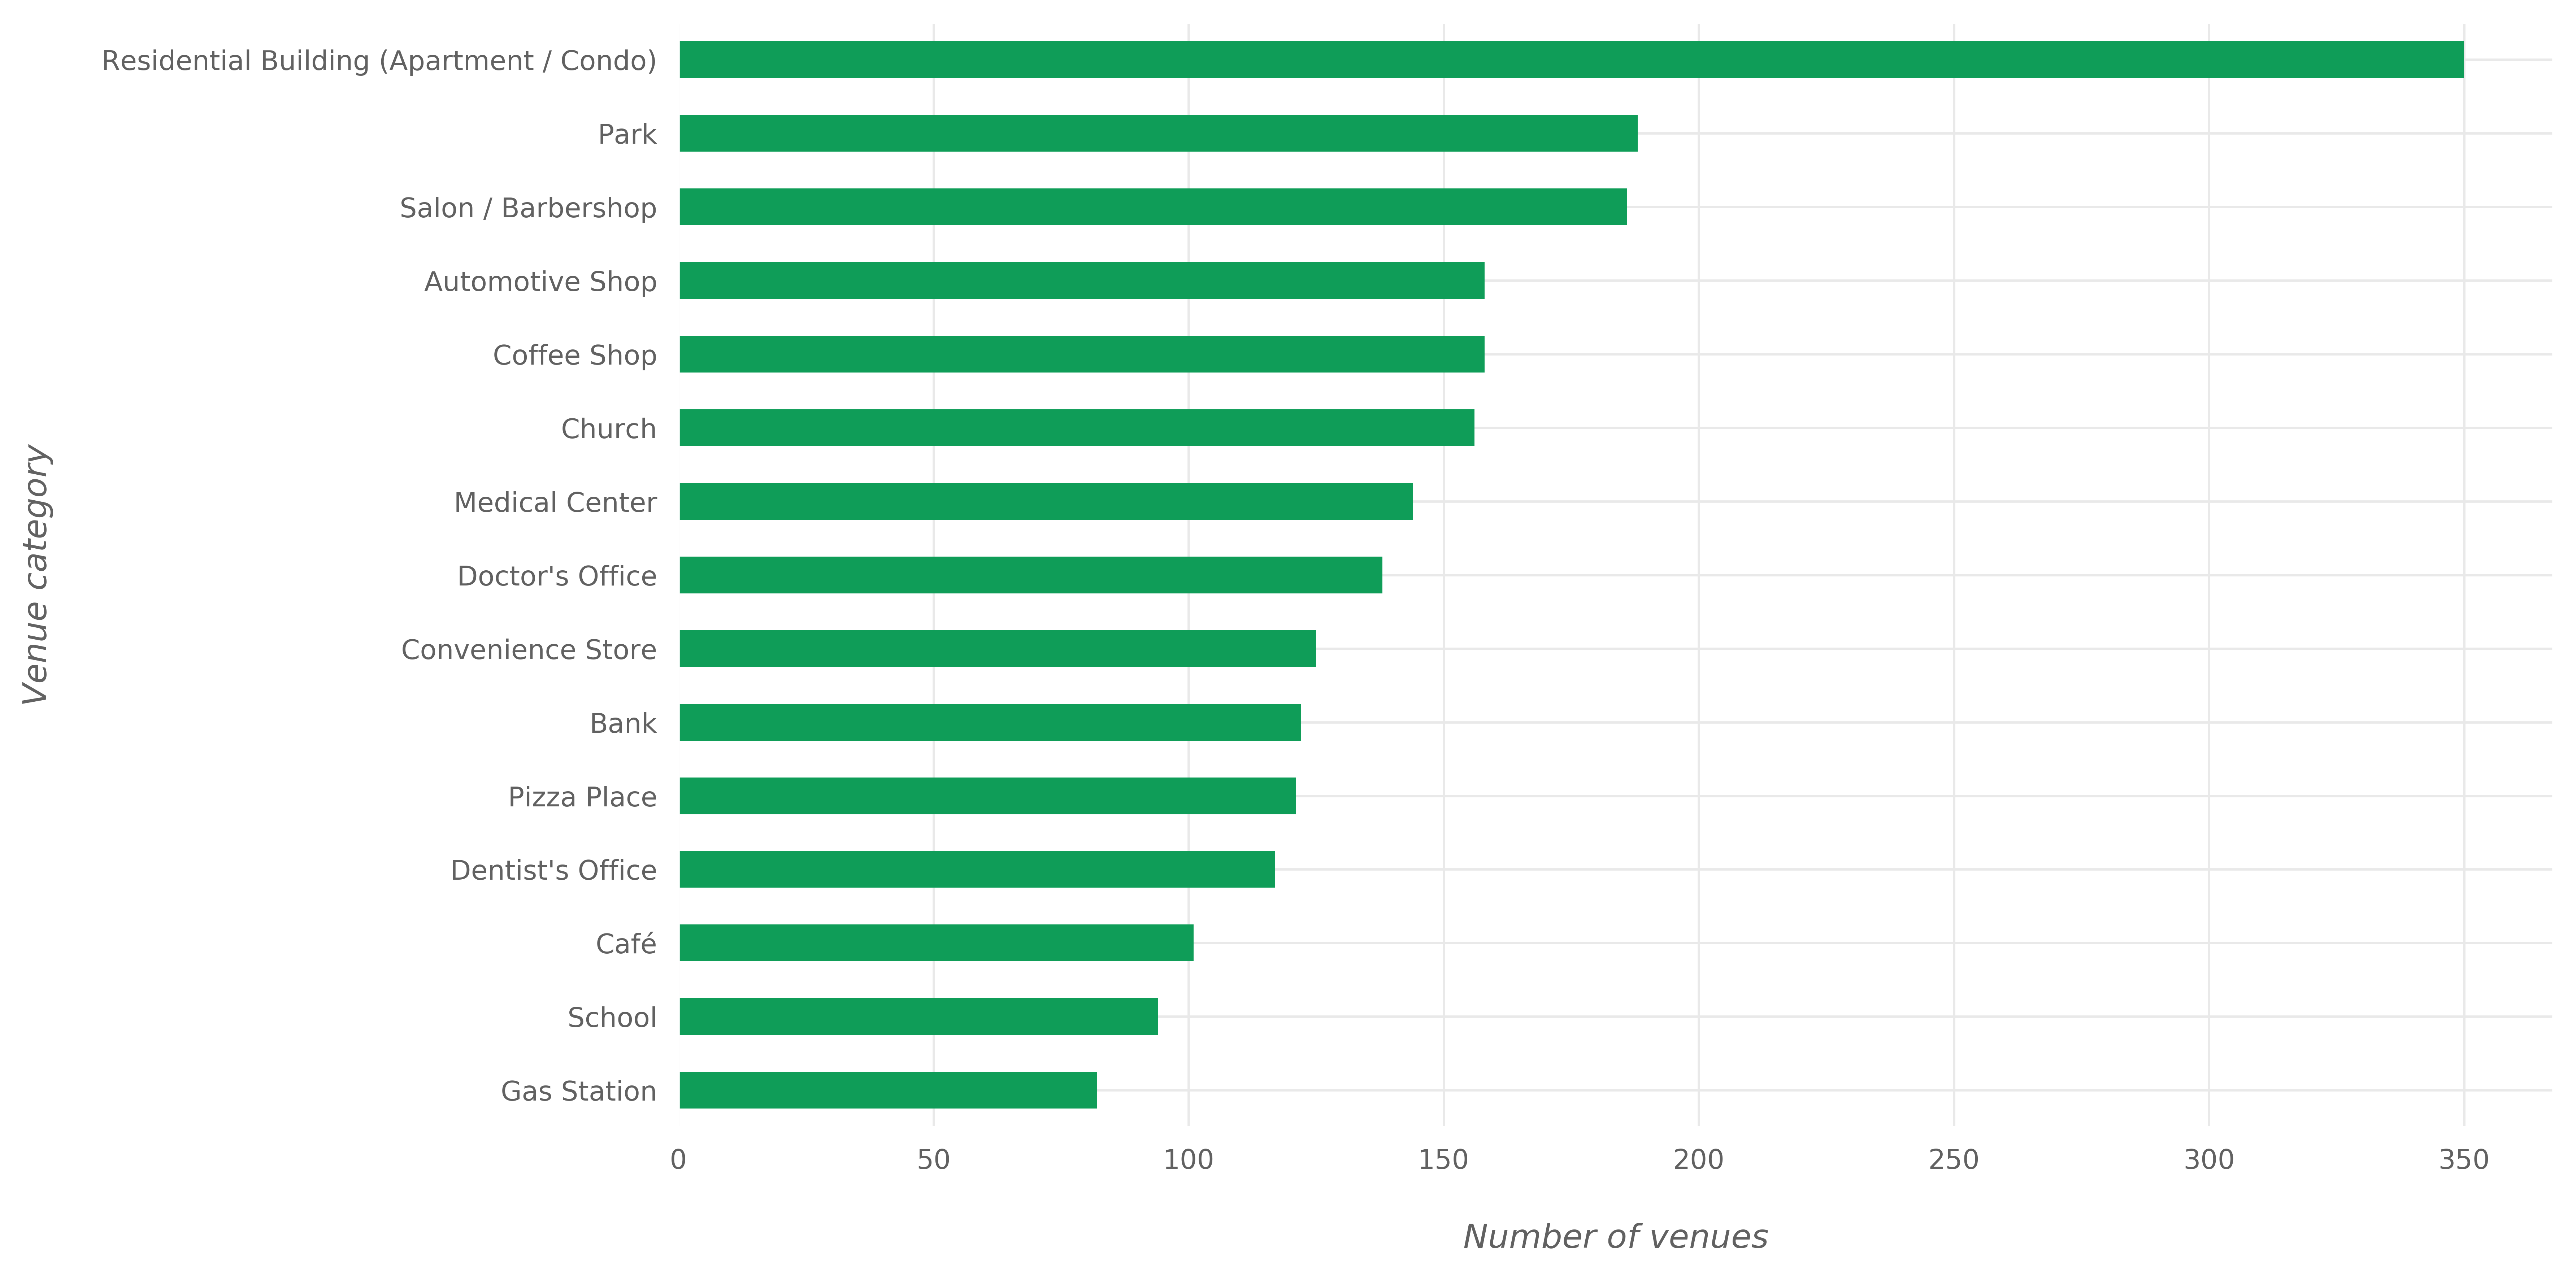

In [105]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_top_vc = tor_venues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color=pc[3]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of venues', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

Which Venue Categories Exist in More Toronto Neighborhoods?

99 neighborhoods in Toronto


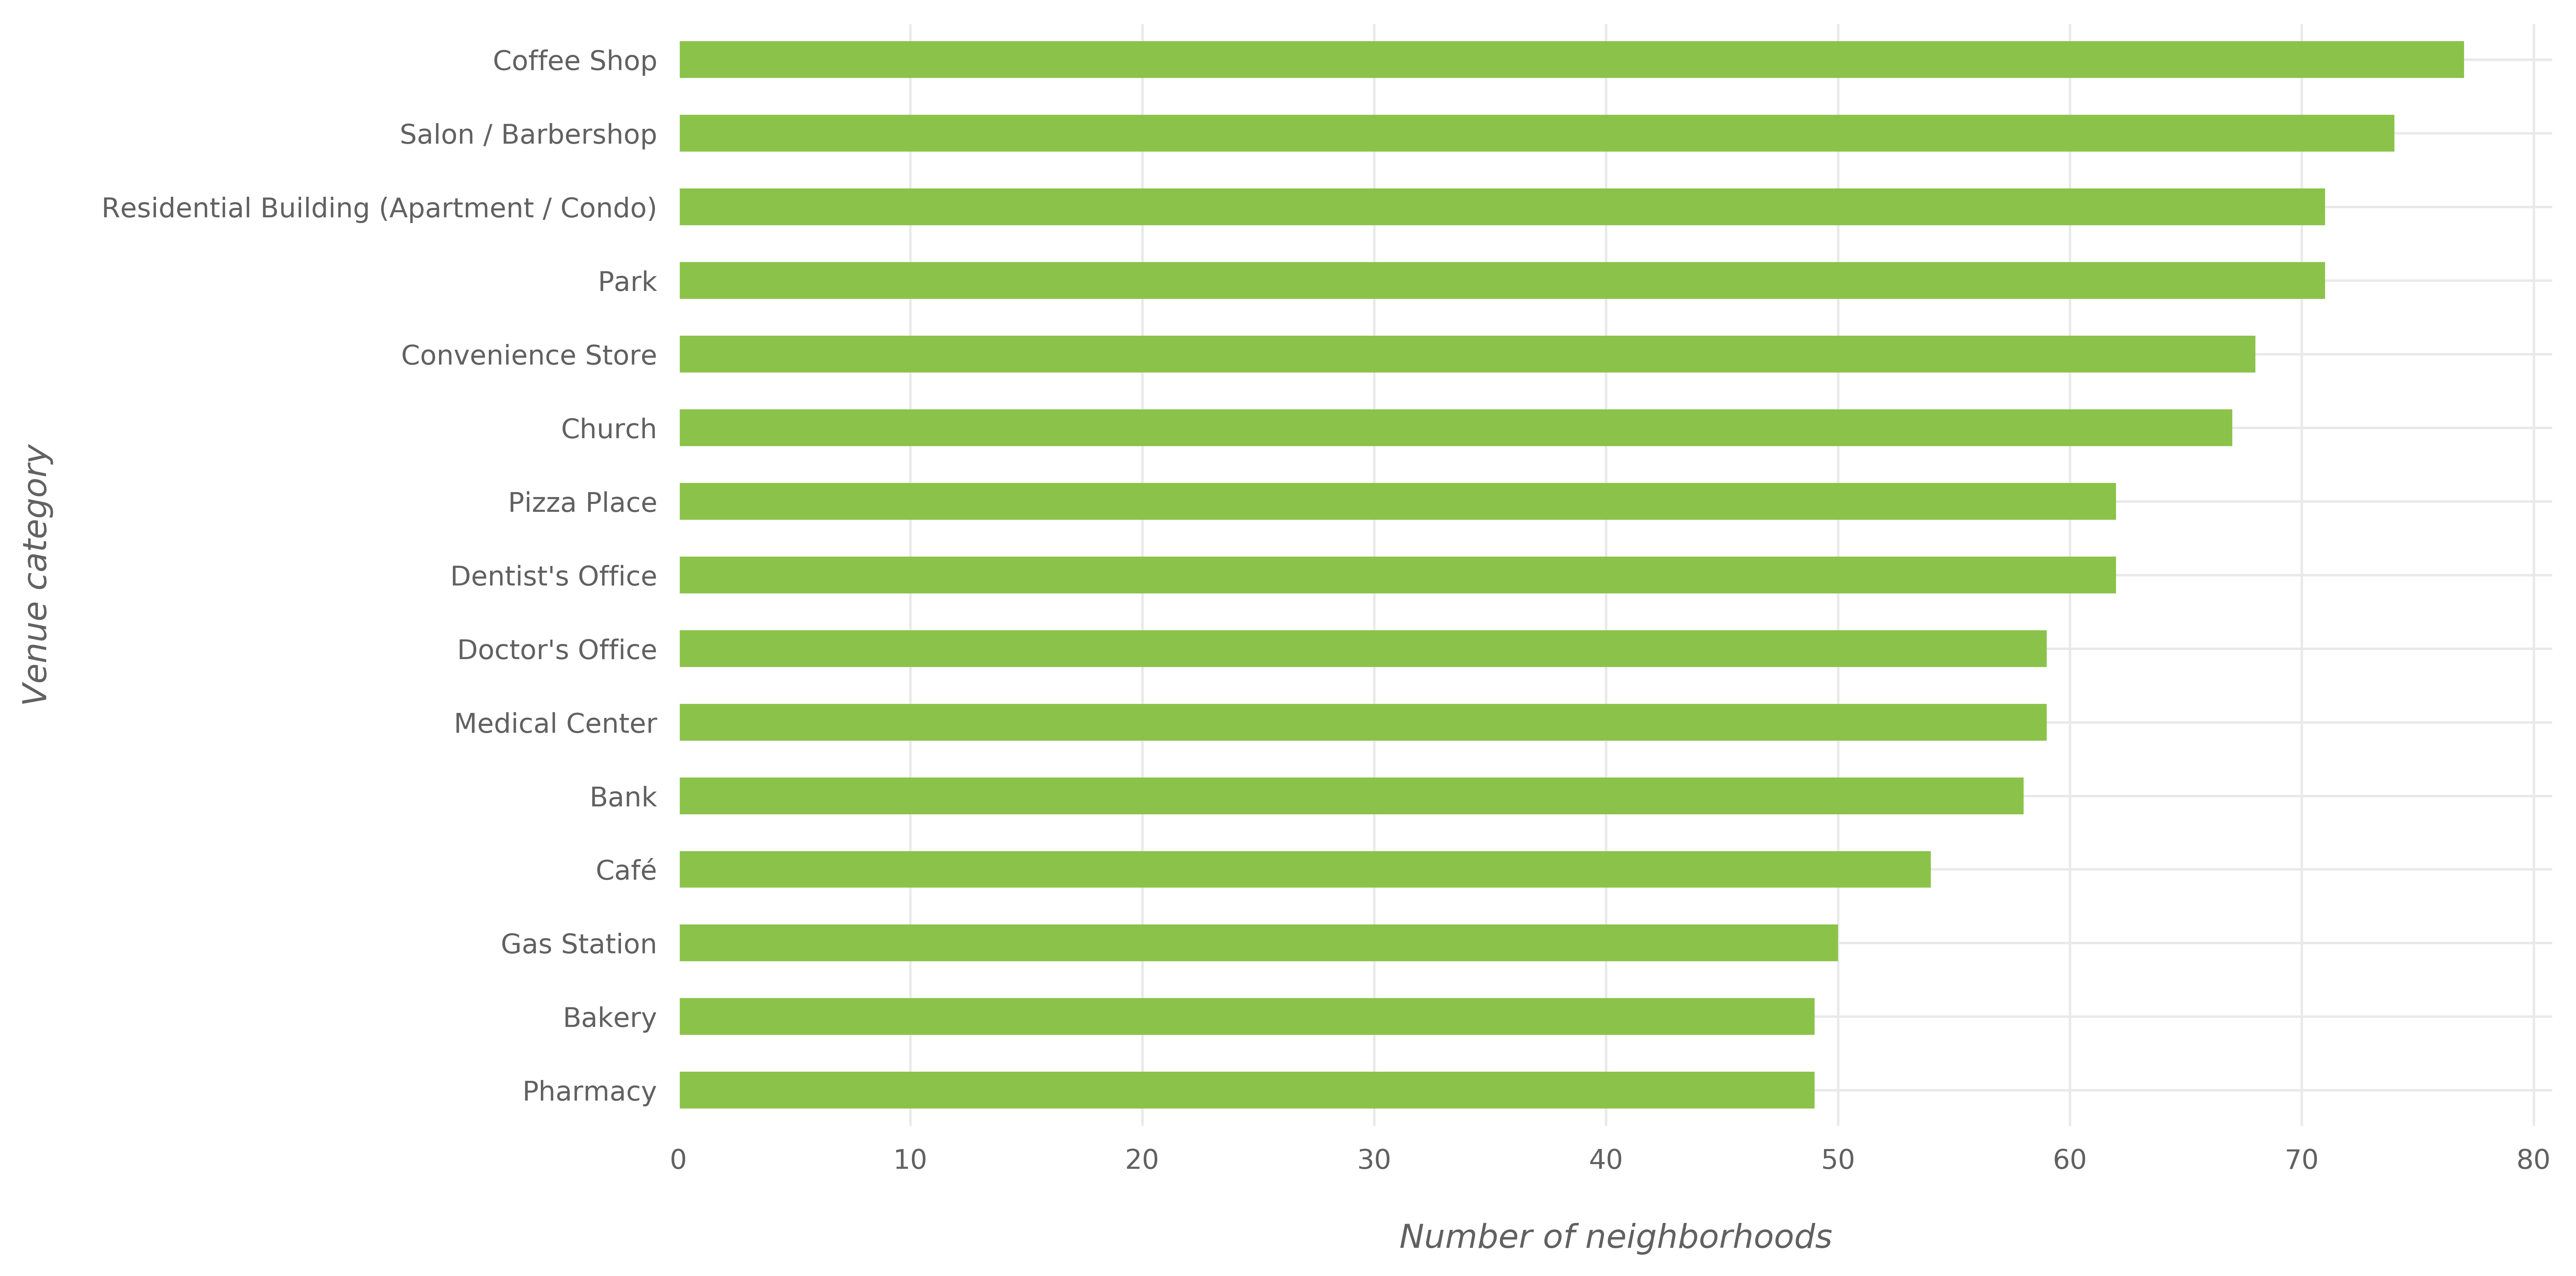

In [106]:
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
tor_g = tor_onehot.groupby('Neighborhood_').max().reset_index()
tor_p = tor_g.drop('Neighborhood_', axis=1).sum().sort_values(ascending=False)
print("{} neighborhoods in Toronto".format(tor_g.shape[0]))
ax = tor_p.head(15).plot(kind='barh', color=pc[14]);
ax.invert_yaxis()
plot_conf(ax, xlbl='Number of neighborhoods', ylbl='Venue category', t='')
plt.tight_layout()
fig.savefig('most-common2-ven-tor.png', dpi=300)

Rare categories in Toronto

In [107]:
tor_bot_vc = tor_venues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

,Count
Venue Category,
College Track,1
Shawarma Place,1
Sports Club,1
Cooking School,1
Prayer Room,1
College Math Building,1
Corporate Coffee Shop,1
Outdoors & Recreation,1
Peking Duck Restaurant,1
